# cmip Events

Get the indeces from traditional and EC calcs and determine events

In [1]:
import xarray
import numpy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches


In [2]:
#import my functions
import utils._modelDefinitions as _model
import utils._indexDefinitions as _index
import utils.sstIndex as sst
import utils.pslIndex as psl
import utils.timePeriod as tp
import utils.compound as compound
import utils.ecIndex as ec
import utils.overlapBins as overlapBins


# Find events in the e and c indeces

 1 sigma above/below mean
Using a piControl climatology

In [3]:
ecXr=xarray.open_dataset('results/cmip6EcIndex.nc').sel(model=_model.scenarioMip[:,1])

piControlEcXr=ecXr.sel(experiment='piControl', drop=True)


# This should calculate stds for all experiments and all indeces
stdEcXr = piControlEcXr.std(dim='year')
stdEcXr

<xarray.Dataset>
Dimensions:  (model: 35)
Coordinates:
  * model    (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
Data variables:
    eIndex   (model) float64 0.6339 0.8717 0.6902 0.6543 ... 0.7986 0.75 0.7068
    cIndex   (model) float64 0.962 0.8771 0.8874 0.8806 ... 0.841 0.8212 0.8975

Apply the 1 sigma criteria

In [4]:
firePosEc, fireNegEc = compound.applyCriteria(ecXr, stdEcXr)

firePos: 
['cIndex', 'eIndex']
fireNeg: 
[]


In [5]:
# find where either index is saying there is an event
# this is a bit messy, you need to make sure Nan years stay as Nan (years for the piControl is different for all the models)

firePosEc['ecCombined']=(((firePosEc.cIndex+firePosEc.eIndex)>0)*1).where(
        firePosEc.cIndex.isnull()==False)
fireNegEc['ecCombined']=(((fireNegEc.cIndex+fireNegEc.eIndex)>0)*1).where(
    fireNegEc.cIndex.isnull()==False)


In [6]:
#open events in the trad indeces
tradIndecesXr = xarray.concat([
    xarray.open_dataset('results/cmip6'+experiment+'TradIndecesTos.nc').sel(model=_model.scenarioMip[:,1]) for experiment in ['piControl','ssp585']], 
'experiment')

tradIndecesXr['experiment']=['piControl','ssp585']



In [7]:
piControlXr=tradIndecesXr.sel(experiment='piControl',drop=True)

piControlXr.model.values

array(['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR',
       'CAMS-CSM1-0', 'CAS-ESM2-0', 'CESM2', 'CESM2-WACCM', 'CIESM',
       'CMCC-CM2-SR5', 'CMCC-ESM2', 'CNRM-CM6-1', 'CNRM-ESM2-1',
       'CanESM5', 'CanESM5-CanOE', 'EC-Earth3', 'EC-Earth3-CC',
       'EC-Earth3-Veg', 'EC-Earth3-Veg-LR', 'GFDL-CM4', 'GFDL-ESM4',
       'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'INM-CM4-8', 'INM-CM5-0',
       'IPSL-CM6A-LR', 'MCM-UA-1-0', 'MIROC-ES2L', 'MIROC6',
       'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NorESM2-LM',
       'NorESM2-MM', 'UKESM1-0-LL'], dtype=object)

In [8]:
stdXr = piControlXr.std(dim='year')

criteriaXr= xarray.merge(
    (stdXr[['nino3','nino34','nino4','dmi','eastIO']],
     stdXr[['samWinter','samSummer']]/2)
)

In [9]:
firePosTrad, fireNegTrad = compound.applyCriteria(tradIndecesXr, criteriaXr)


firePos: 
['dmi', 'nino3', 'nino34', 'samWinter', 'nino4']
fireNeg: 
['eastIO', 'samSummer']


Now we can merge the events from each method

In [10]:
firePos=xarray.merge([firePosEc,firePosTrad])
fireNeg=xarray.merge([fireNegEc,fireNegTrad])

In [11]:
fireXr=xarray.concat([firePos,fireNeg], 'fire')
fireXr['fire']=['pos','neg']

fireXr.to_netcdf('results/cmipEcEvents.nc')


# an attempt at a summary plot

In [12]:
fireXr=xarray.open_dataset('results/cmipEcEvents.nc')

In [13]:
summaryXr=fireXr[['ecCombined','dmi','samWinter','samSummer']].sel(
    experiment='ssp585', 
    year=slice(1850,2099),
    drop=True
)

In [14]:
nEventsCurrentXr=summaryXr.sel(year=slice(1950,1999),drop=True).sum('year')
nEventsFutureXr=summaryXr.sel(year=slice(2050,2099),drop=True).sum('year')


In [15]:
import scipy.stats as stats
for iIndex in ['ecCombined','dmi','samWinter','samSummer']:
    print(iIndex)
    for iFire in ['pos','neg']:
        print(iFire)
        print(stats.kstest(
            nEventsCurrentXr[iIndex].sel(fire=iFire,drop=True),
            nEventsFutureXr[iIndex].sel(fire=iFire,drop=True)
        ))

ecCombined
pos
KstestResult(statistic=0.7428571428571429, pvalue=1.1593847273599567e-09)
neg
KstestResult(statistic=0.42857142857142855, pvalue=0.002885996519380205)
dmi
pos
KstestResult(statistic=0.8285714285714286, pvalue=2.3374692083870097e-12)
neg
KstestResult(statistic=0.6, pvalue=3.4452298564531986e-06)
samWinter
pos
KstestResult(statistic=0.9714285714285714, pvalue=1.2479244585402055e-18)
neg
KstestResult(statistic=0.9714285714285714, pvalue=1.2479244585402055e-18)
samSummer
pos
KstestResult(statistic=0.9428571428571428, pvalue=4.305339381963709e-17)
neg
KstestResult(statistic=0.9714285714285714, pvalue=1.2479244585402055e-18)


/Users/ajs/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (131220000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


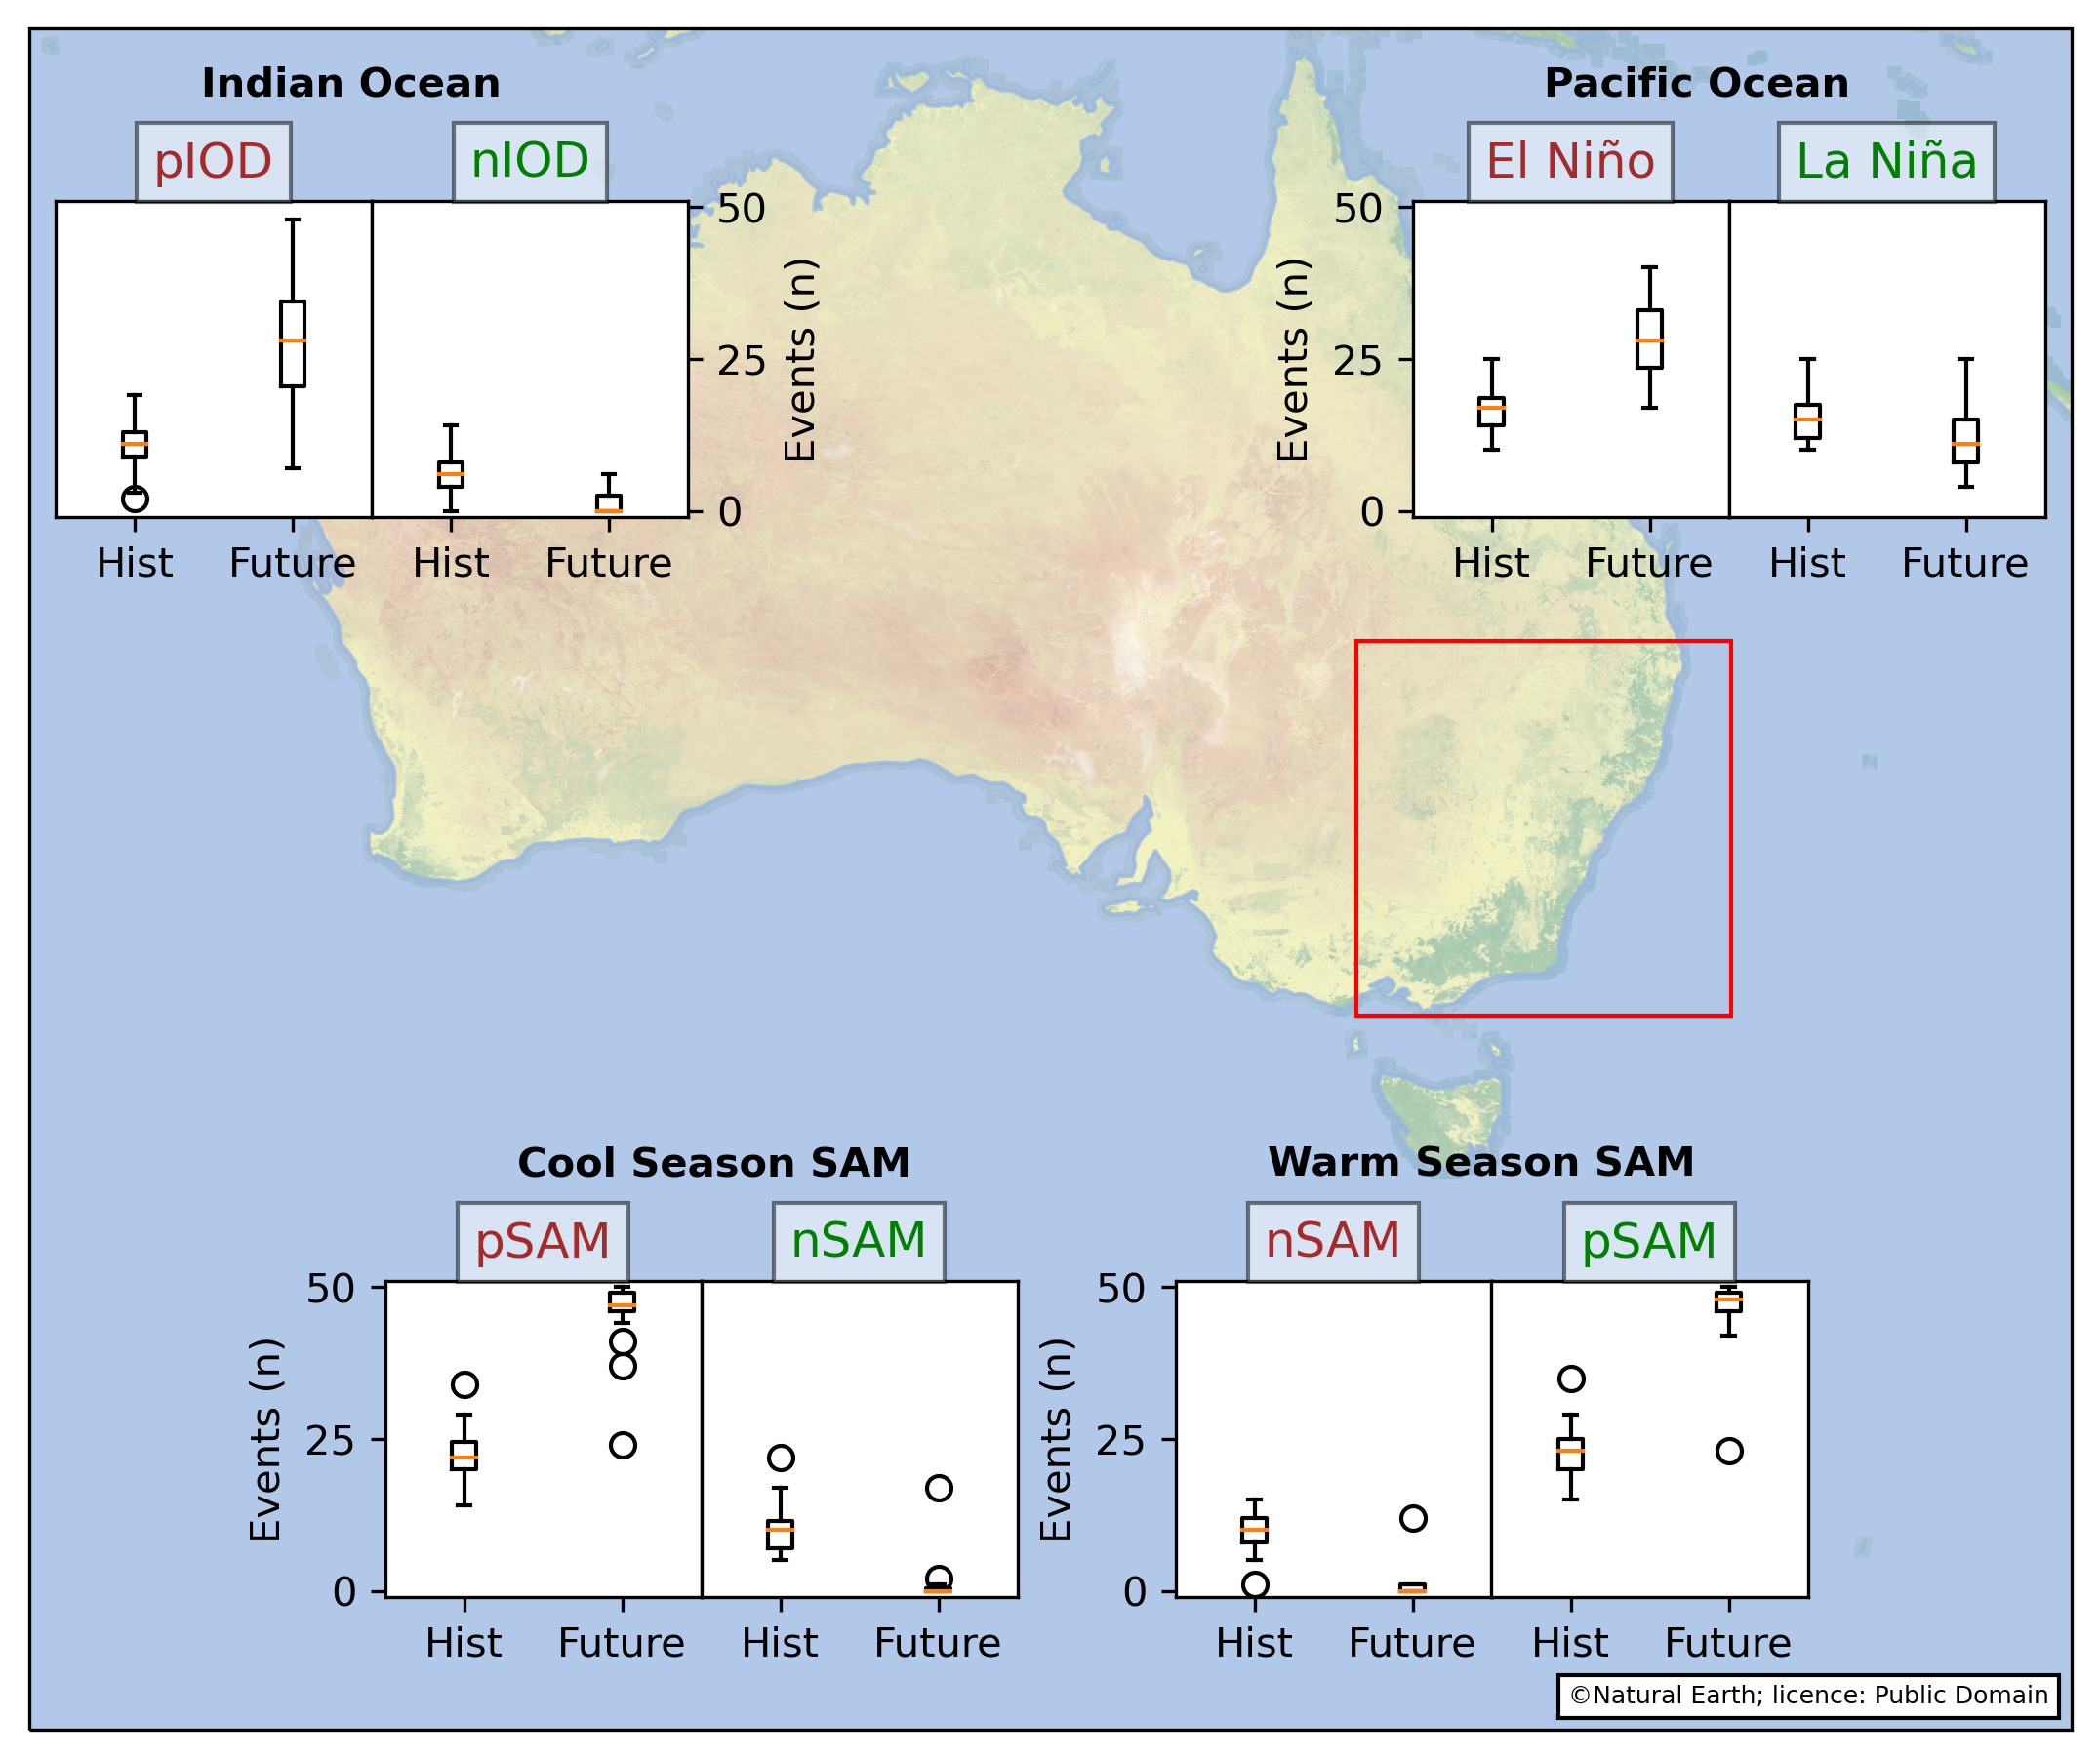

In [16]:
from matplotlib.offsetbox import AnchoredText
import sys
import os

#set location to look for the background image
os.environ["CARTOPY_USER_BACKGROUNDS"] = sys.path[0]+"/ref/"

#new figure
fig=plt.figure(figsize=(9,9), dpi=300)
ax=fig.add_subplot(projection=ccrs.PlateCarree())

#limit to areas around Australia
ax.set_xlim(105,165)
ax.set_ylim(-60,-10)

#add background image
ax.background_img(name="NE1", resolution="low")

#credit: https://scitools.org.uk/cartopy/docs/v0.14/matplotlib/feature_interface.html
ax.add_feature(cfeature.OCEAN, zorder=0.5, alpha =0.75) 

#are of interest
ax.add_patch(
    mpatches.Rectangle(
        xy=[144, -39], 
        width=11, height=11,
        edgecolor='red',facecolor='none' 
    )
)

# Add a text annotation for the license information to the bottom right corner.
text = AnchoredText(
    u"\u00A9" + "Natural Earth; licence: Public Domain",
    loc='lower right', prop={'size': 6}, frameon=True
)
ax.add_artist(text)

#locations to show small plots
axW=0.12 #width of small plots
axH=0.12 #height
axL=0.26 #left of plots
axBot=0.23 #bottom row position
axTop=0.64 #top row position

for iIndex in (
    ['ecCombined','El Niño', 'La Niña',[0.65,axTop,axW,axH],[0.65+axW,axTop,axW,axH] ],
    ['dmi', 'pIOD','nIOD',[0.135,axTop,axW,axH],[0.135+axW,axTop,axW,axH] ],
    ['samWinter','pSAM','nSAM',[axL,axBot,axW,axH],[axL+axW,axBot,axW,axH] ],
    ['samSummer','nSAM','pSAM',[axL+2.5*axW,axBot,axW,axH],[axL+3.5*axW,axBot,axW,axH] ]
):
    #create a little axis for dry promoting events
    ax0=plt.axes(iIndex[3])

    #current and future boxplot
    plt.boxplot([
        nEventsCurrentXr[iIndex[0]].sel(fire='pos',drop=True),
        nEventsFutureXr[iIndex[0]].sel(fire='pos',drop=True)
    ])
    
    #xlabels
    plt.xticks(ticks=[1,2],labels=['Hist','Future'])
    
    #ylabels
    plt.yticks(ticks=[0,25,50])
    if iIndex[0]!='dmi':
        plt.ylabel('Events (n)')
    
    #title
    t=plt.title(iIndex[1], color='brown')
    t.set_bbox(dict(facecolor='white', alpha=0.5))
    
    # repeat for wet promoting events
    ax1=plt.axes(iIndex[4],sharey=ax0)
    plt.boxplot([
        nEventsCurrentXr[iIndex[0]].sel(fire='neg',drop=True),
        nEventsFutureXr[iIndex[0]].sel(fire='neg',drop=True)
    ])
    plt.xticks(ticks=[1,2],labels=['Hist','Future'])
    ax1.axes.yaxis.set_visible(False)
    plt.ylim([-1,51])
    t=plt.title(iIndex[2],color='green')
    t.set_bbox(dict(facecolor='white', alpha=0.5))
    
    # for the indian ocean, put the lavels on the other side
    if iIndex[0]=='dmi':
        plt.ylabel('Events (n)')
        ax0.axes.yaxis.set_visible(False)
        ax1.axes.yaxis.set_visible(True)
        ax1.yaxis.set_label_position("right")
        ax1.yaxis.tick_right()
    
    
# label all the little plots    
_ = plt.figtext(0.19, 0.8, 'Indian Ocean', weight='bold')
_ = plt.figtext(0.70, 0.8, 'Pacific Ocean', weight='bold')
_ = plt.figtext(0.31, 0.39, 'Cool Season SAM',weight='bold')
_ = plt.figtext(0.595, 0.39, 'Warm Season SAM', weight='bold')

plt.savefig('figures/summaryMap.pdf', bbox_inches='tight')


# Index Comparisons - ENSO

In [17]:
%run utils/emergence.ipynb

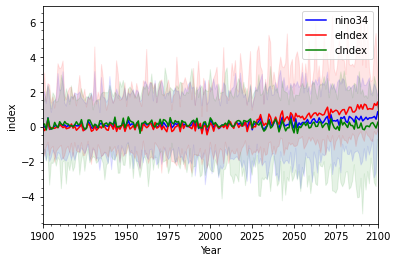

In [18]:
overlaidEmergePlot(
    xarray.merge([
        tradIndecesXr.sel(experiment='ssp585',drop=True).nino34,
        ecXr.sel(experiment='ssp585',drop=True)
    ]), 
)

plt.xlim([1900,2100])
plt.ylabel('index')
plt.legend()

No handles with labels found to put in legend.


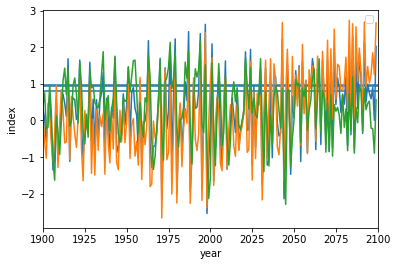

In [19]:
tradIndecesXr.sel(experiment='ssp585',model='CESM2',drop=True).nino34.plot()
ecXr.sel(experiment='ssp585',model='CESM2',drop=True).eIndex.plot()
ecXr.sel(experiment='ssp585',model='CESM2',drop=True).cIndex.plot()

plt.hlines(
    [
        stdEcXr.eIndex.sel(model='CESM2'),
        stdEcXr.cIndex.sel(model='CESM2'),
        stdXr.nino34.sel(model='CESM2')
    ],
    1900,2100
)

plt.xlim([1900,2100])
plt.ylabel('index')
plt.legend()

# Index Comparisons - IOD

Text(0, 0.5, 'index')

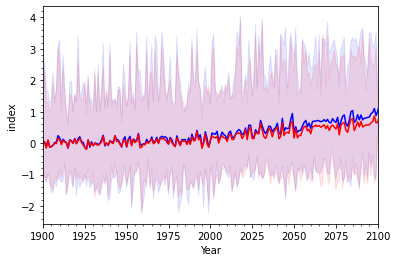

In [20]:
overlaidEmergePlot(
    xarray.merge([
        tradIndecesXr.sel(experiment='ssp585',drop=True).dmi,
        (tradIndecesXr.sel(experiment='ssp585',drop=True).eastIO*-1)
    ]), 
)

plt.xlim([1900,2100])
plt.ylabel('index')

# Put the resutls in 30 year bins

In [21]:
fireXr=xarray.open_dataset('results/cmipEcEvents.nc')

In [22]:
#ssp585
fireBinnedXr=overlapBins.binSum(fireXr.sel(experiment='ssp585', year=slice(1850,2100),drop=True))


In [23]:
fireBinnedXr

<xarray.Dataset>
Dimensions:     (year: 23, fire: 2, model: 35)
Coordinates:
  * model       (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
  * fire        (fire) object 'pos' 'neg'
  * year        (year) int64 1865 1875 1885 1895 1905 ... 2055 2065 2075 2085
Data variables:
    cIndex      (year, fire, model) float64 6.0 2.0 7.0 5.0 ... 13.0 10.0 6.0
    eIndex      (year, fire, model) float64 3.0 7.0 6.0 4.0 ... 1.0 1.0 0.0 0.0
    ecCombined  (year, fire, model) float64 7.0 8.0 10.0 9.0 ... 13.0 10.0 6.0
    dmi         (year, fire, model) float64 7.0 2.0 4.0 5.0 ... 2.0 0.0 0.0 0.0
    nino3       (year, fire, model) float64 5.0 3.0 5.0 5.0 ... 2.0 7.0 5.0 1.0
    nino34      (year, fire, model) float64 6.0 2.0 4.0 4.0 ... 2.0 9.0 10.0 2.0
    samWinter   (year, fire, model) float64 5.0 11.0 12.0 13.0 ... 0.0 0.0 0.0
    nino4       (year, fire, model) float64 5.0 2.0 5.0 6.0 ... 3.0 7.0 7.0 2.0
    eastIO      (year, fire, model) float64 7.0 4.0 4.0 4.0 ... 3.0 4.0 3.0 0.0
    samSummer   (year, fire, model) float64 14.0 6.0 11.0 ... 29.0 30.0 30.0
Attributes:
    Bins:     Overlapping 30 year bins, seperating by 10 year intervals
    Year:     Midpoint of bin

In [24]:
# and for piControl
binSumLs = list()

#using bin sum is a bit funky because the models have different start and end years
#run binSum for each model seperately, after filtering the nans
for iModel in _model.scenarioMip[:,1]:
    try:
        piCModelXr=fireXr.sel(experiment='piControl', drop=True).sel(model=iModel)
        binSumXr=overlapBins.binSum(piCModelXr.where(piCModelXr.isnull()==False, drop=True))
        binSumLs.append(binSumXr)
        
    except Exception as e:
        print(e)
        
piControlBinnedXr = xarray.concat(binSumLs, 'model')

In [25]:
piControlBinnedXr

<xarray.Dataset>
Dimensions:     (year: 774, model: 35, fire: 2)
Coordinates:
  * year        (year) int64 16 26 36 46 56 66 ... 6126 6136 6146 6156 6166 6176
  * model       (model) <U16 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
  * fire        (fire) object 'pos' 'neg'
Data variables:
    cIndex      (model, year, fire) float64 nan nan nan nan ... nan nan nan nan
    eIndex      (model, year, fire) float64 nan nan nan nan ... nan nan nan nan
    ecCombined  (model, year, fire) float64 nan nan nan nan ... nan nan nan nan
    dmi         (model, year, fire) float64 nan nan nan nan ... nan nan nan nan
    nino3       (model, year, fire) float64 nan nan nan nan ... nan nan nan nan
    nino34      (model, year, fire) float64 nan nan nan nan ... nan nan nan nan
    samWinter   (model, year, fire) float64 nan nan nan nan ... nan nan nan nan
    nino4       (model, year, fire) float64 nan nan nan nan ... nan nan nan nan
    eastIO      (model, year, fire) float64 nan nan nan nan ... nan nan nan nan
    samSummer   (model, year, fire) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    Bins:     Overlapping 30 year bins, seperating by 10 year intervals
    Year:     Midpoint of bin

In [26]:
firePosBinnedXr=fireBinnedXr.sel(fire='pos', drop=True)
piControlPosBinnedXr=piControlBinnedXr.sel(fire='pos', drop=True)

fireNegBinnedXr=fireBinnedXr.sel(fire='neg', drop=True)
piControlNegBinnedXr=piControlBinnedXr.sel(fire='neg', drop=True)

# How do they look when compounded?

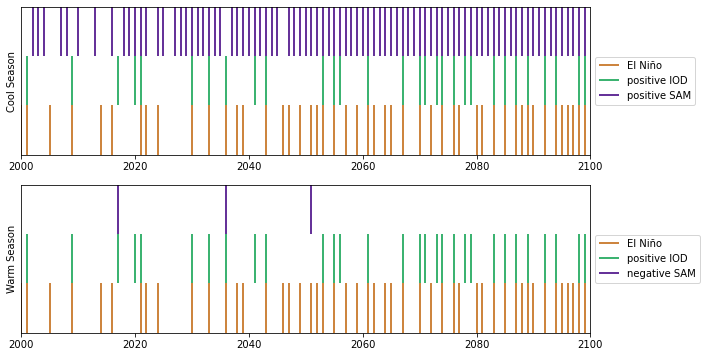

In [27]:
plt.figure(figsize=(12,6))

colors = ['peru', 'mediumseagreen', 'rebeccapurple']
indeces = ['ecCombined','dmi','samWinter']

toPlot=fireXr.sel(
    fire='pos',
    experiment='ssp585',
    year=slice(1900,2099),
    model='CESM2',
    drop=True
)

ax=plt.subplot(2,1,1)



iPlot=0
for iIndex in indeces:
    plt.vlines(
        x=toPlot[iIndex].where(toPlot[iIndex],drop=True).year, 
        ymin=iPlot,
        ymax=(iPlot+1),#*(toPlot[iIndex].where(toPlot[iIndex])),
        color=colors[iPlot], 
        linewidth=2
    )
    iPlot=iPlot+1
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.85, box.height])

# Put a legend to the right of the current axis
plt.legend(['El Niño','positive IOD','positive SAM'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(2000,2100)
plt.ylim([0,3])
plt.yticks([])
plt.ylabel('Cool Season')


ax=plt.subplot(2,1,2)

indeces = ['ecCombined','dmi','samSummer']


iPlot=0
for iIndex in indeces:
    plt.vlines(
        x=toPlot[iIndex].where(toPlot[iIndex],drop=True).year, 
        ymin=iPlot,
        ymax=(iPlot+1),#*(toPlot[iIndex].where(toPlot[iIndex])),
        color=colors[iPlot], 
        linewidth=2
    )
    iPlot=iPlot+1
    
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.85, box.height])

# Put a legend to the right of the current axis
plt.legend(['El Niño','positive IOD','negative SAM'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(2000,2100)
plt.ylim([0,3])
plt.yticks([])
plt.ylabel('Warm Season')

plt.savefig('figures/cmip6compoundExampleDry.pdf',bbox_inches='tight')

# Calculate the compounding years

In [28]:
allCompoundsXr=xarray.concat([
    compound.compound(firePos),
    compound.compound(fireNeg)],
    'fire')

allCompoundsXr['fire']=['pos','neg']



ecCombinedDmiSamwinter
ecCombinedDmiSamsummer
ecCombinedEastioSamwinter
ecCombinedEastioSamsummer
eIndexDmiSamwinter
eIndexDmiSamsummer
eIndexEastioSamwinter
eIndexEastioSamsummer
nino3DmiSamwinter
nino3DmiSamsummer
nino3EastioSamwinter
nino3EastioSamsummer
nino34DmiSamwinter
nino34DmiSamsummer
nino34EastioSamwinter
nino34EastioSamsummer
cIndexDmiSamwinter
cIndexDmiSamsummer
cIndexEastioSamwinter
cIndexEastioSamsummer
nino4DmiSamwinter
nino4DmiSamsummer
nino4EastioSamwinter
nino4EastioSamsummer
ecCombinedDmiSamwinter
ecCombinedDmiSamsummer
ecCombinedEastioSamwinter
ecCombinedEastioSamsummer
eIndexDmiSamwinter
eIndexDmiSamsummer
eIndexEastioSamwinter
eIndexEastioSamsummer
nino3DmiSamwinter
nino3DmiSamsummer
nino3EastioSamwinter
nino3EastioSamsummer
nino34DmiSamwinter
nino34DmiSamsummer
nino34EastioSamwinter
nino34EastioSamsummer
cIndexDmiSamwinter
cIndexDmiSamsummer
cIndexEastioSamwinter
cIndexEastioSamsummer
nino4DmiSamwinter
nino4DmiSamsummer
nino4EastioSamwinter
nino4EastioSamsummer


That is a bit of a crazy long list, so well be a little bit selective in the ones we save

In [29]:
compoundNames= [
    #'nino4EastioSamwinter',
    #'nino4EastioSamsummer',
    #'nino4DmiSamwinter',
    #'nino4DmiSamsummer',
    'nino34EastioSamwinter',
    'nino34EastioSamsummer',
    'nino34DmiSamwinter',
    'nino34DmiSamsummer',
    'cIndexEastioSamwinter',
    'cIndexEastioSamsummer',
    'cIndexDmiSamwinter',
    'cIndexDmiSamsummer',
    'eIndexEastioSamwinter',
    'eIndexEastioSamsummer',
    'eIndexDmiSamwinter',
    'eIndexDmiSamsummer',
    'ecCombinedEastioSamwinter',
    'ecCombinedEastioSamsummer',
    'ecCombinedDmiSamwinter',
    'ecCombinedDmiSamsummer'
]

In [31]:
allCompoundsXr[compoundNames].to_netcdf('results/cmip6Compounds.nc') 

In [32]:
#example
allCompoundsXr.sel(compound='all3',fire='pos',experiment='ssp585',year=slice(1950,2000),drop=True)

<xarray.Dataset>
Dimensions:                    (year: 51, model: 35)
Coordinates:
  * year                       (year) int64 1950 1951 1952 ... 1998 1999 2000
  * model                      (model) object 'ACCESS-CM2' ... 'UKESM1-0-LL'
Data variables: (12/24)
    ecCombinedDmiSamwinter     (model, year) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ecCombinedDmiSamsummer     (model, year) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ecCombinedEastioSamwinter  (model, year) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ecCombinedEastioSamsummer  (model, year) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    eIndexDmiSamwinter         (model, year) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    eIndexDmiSamsummer         (model, year) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...                         ...
    cIndexEastioSamwinter      (model, year) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cIndexEastioSamsummer      (model, year) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    nino4DmiSamwinter          (model, year) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    nino4DmiSamsummer          (model, year) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    nino4EastioSamwinter       (model, year) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    nino4EastioSamsummer       (model, year) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    indexNames:  ['ecCombined', 'dmi', 'samWinter']
    indeces:     ['enso', 'iod', 'sam']
    pairs:       ['enso+iod', 'enso+sam', 'iod+sam']
    others:      ['all3', 'anyCompound', 'nEvents']